## Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

## Import Env File

In [2]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparameters

In [4]:
num_classes = 2  
batch_size = 16
num_epochs = 20
learning_rate = 0.001
test_split_ratio = 0.2
image_size = (224, 224)

## Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Data Loaders

In [6]:
# Dataset
dataset = datasets.ImageFolder(root=datasets_path, transform=transform)

# Split dataset into training and testing
test_size = int(test_split_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Cetak semua label kelas di dalam dataset
print("Daftar kelas dalam dataset:")
print(dataset.classes)

Daftar kelas dalam dataset:
['jogja', 'pekalongan']


## load Pre-Trained Model

In [ ]:
# Load pre-trained EfficientNet
model = models.efficientnet_b0(pretrained=True) 

# Customize the classifier (dense layer)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),  # Dense layer baru
    nn.ReLU(),                                       # Activation function
    nn.Dropout(0.3),                                 # Dropout 
    nn.Linear(512, num_classes)                      # Output layer 
)
model = model.to(device)

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train The Model

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.7903
Epoch [2/20], Loss: 0.1340
Epoch [3/20], Loss: 0.0280
Epoch [4/20], Loss: 0.1196
Epoch [5/20], Loss: 0.8445
Epoch [6/20], Loss: 1.2304
Epoch [7/20], Loss: 0.0676
Epoch [8/20], Loss: 0.1898
Epoch [9/20], Loss: 0.0096
Epoch [10/20], Loss: 0.0271
Epoch [11/20], Loss: 0.0927
Epoch [12/20], Loss: 0.1214
Epoch [13/20], Loss: 0.0623
Epoch [14/20], Loss: 0.0168
Epoch [15/20], Loss: 0.0031
Epoch [16/20], Loss: 0.0091
Epoch [17/20], Loss: 0.0022
Epoch [18/20], Loss: 0.0008
Epoch [19/20], Loss: 0.0091
Epoch [20/20], Loss: 0.0025


## Evaluation

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi klasifikasi
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8571    0.9000    0.8780        20
           1     0.8889    0.8421    0.8649        19

    accuracy                         0.8718        39
   macro avg     0.8730    0.8711    0.8715        39
weighted avg     0.8726    0.8718    0.8716        39



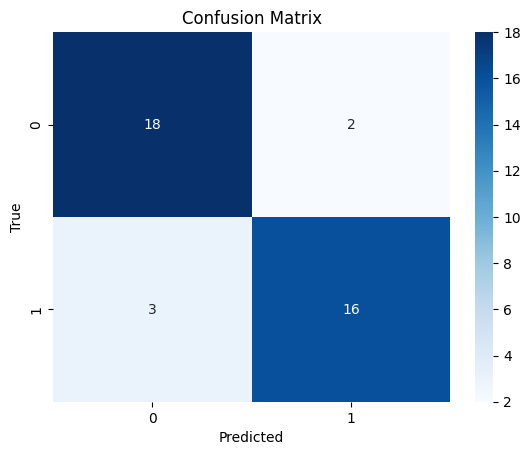

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [13]:
torch.save(model.state_dict(), models_path+'/CNN.pth')